In [2]:
import numpy as np
import jdc
import tensorflow as tf
from distutils.version import StrictVersion

from maci.misc import logger
from maci.misc.overrides import overrides
from maci.misc import tf_utils

from maci.learners.base import MARLAlgorithm

EPS = 1e-6

In [3]:
def adaptive_isotropic_gaussian_kernel(xs, ys, h_min=1e-3):
    """Gaussian kernel with dynamic bandwidth.
    The bandwidth is adjusted dynamically to match median_distance / log(Kx).
    See [2] for more information.
    Args:
        xs(`tf.Tensor`): A tensor of shape (N x Kx x D) containing N sets of Kx
            particles of dimension D. This is the first kernel argument.
        ys(`tf.Tensor`): A tensor of shape (N x Ky x D) containing N sets of Kx
            particles of dimension D. This is the second kernel argument.
        h_min(`float`): Minimum bandwidth.
    Returns:
        `dict`: Returned dictionary has two fields:
            'output': A `tf.Tensor` object of shape (N x Kx x Ky) representing
                the kernel matrix for inputs `xs` and `ys`.
            'gradient': A 'tf.Tensor` object of shape (N x Kx x Ky x D)
                representing the gradient of the kernel with respect to `xs`.
    Reference:
        [2] Qiang Liu,Dilin Wang, "Stein Variational Gradient Descent: A General
            Purpose Bayesian Inference Algorithm," Neural Information Processing
            Systems (NIPS), 2016.
    """
    Kx, D = xs.get_shape().as_list()[-2:]
    Ky, D2 = ys.get_shape().as_list()[-2:]
    assert D == D2

    leading_shape = tf.shape(xs)[:-2]

    # Compute the pairwise distances of left and right particles.
    diff = tf.expand_dims(xs, -2) - tf.expand_dims(ys, -3)
    # ... x Kx x Ky x D

    if StrictVersion(tf.__version__) < StrictVersion('1.5.0'):
        dist_sq = tf.reduce_sum(diff**2, axis=-1, keep_dims=False)
    else:
        dist_sq = tf.reduce_sum(diff**2, axis=-1, keepdims=False)
    # ... x Kx x Ky

    # Get median.
    input_shape = tf.concat((leading_shape, [Kx * Ky]), axis=0)
    values, _ = tf.nn.top_k(
        input=tf.reshape(dist_sq, input_shape),
        k=(Kx * Ky // 2 + 1),  # This is exactly true only if Kx*Ky is odd.
        sorted=True)  # ... x floor(Ks*Kd/2)

    medians_sq = values[..., -1]  # ... (shape) (last element is the median)

    h = medians_sq / np.log(Kx)  # ... (shape)
    h = tf.maximum(h, h_min)
    h = tf.stop_gradient(h)  # Just in case.
    h_expanded_twice = tf.expand_dims(tf.expand_dims(h, -1), -1)
    # ... x 1 x 1

    kappa = tf.exp(-dist_sq / h_expanded_twice)  # ... x Kx x Ky

    # Construct the gradient
    h_expanded_thrice = tf.expand_dims(h_expanded_twice, -1)
    # ... x 1 x 1 x 1
    kappa_expanded = tf.expand_dims(kappa, -1)  # ... x Kx x Ky x 1

    kappa_grad = -2 * diff / h_expanded_thrice * kappa_expanded
    # ... x Kx x Ky x D

    return {"output": kappa, "gradient": kappa_grad}

In [4]:
def assert_shape(tensor, expected_shape):
    tensor_shape = tensor.shape.as_list()
    assert len(tensor_shape) == len(expected_shape)
    assert all([a == b for a, b in zip(tensor_shape, expected_shape)])

In [5]:
class MASQL(MARLAlgorithm):
    def __init__(
            self,
            base_kwargs,
            agent_id,
            env,
            pool,
            qf,
            target_qf,
            policy,
            plotter=None,
            policy_lr=1E-3,
            qf_lr=1E-3,
            tau=0.01,
            value_n_particles=16,
            td_target_update_interval=1,
            kernel_fn=adaptive_isotropic_gaussian_kernel,
            kernel_n_particles=16,
            kernel_update_ratio=0.5,
            discount=0.99,
            reward_scale=.1,
            joint=True,
            use_saved_qf=False,
            use_saved_policy=False,
            save_full_state=False,
            train_qf=True,
            train_policy=True,
            joint_policy=True,
            opponent_action_range=None,
            opponent_action_range_normalize=True
    ):
        super(MASQL, self).__init__(**base_kwargs)


        self._env = env
        self._pool = pool
        self.qf = qf
        self.target_qf = target_qf
        self._policy = policy
        self.plotter = plotter

        self.agent_id = agent_id

        self._qf_lr = qf_lr
        self._policy_lr = policy_lr
        self._tau = tau
        self._discount = discount
        self._reward_scale = reward_scale
        self.joint_policy = joint_policy
        self.opponent_action_range = opponent_action_range
        self.opponent_action_range_normalize = opponent_action_range_normalize

        self.joint = joint
        self._value_n_particles = value_n_particles
        self._qf_target_update_interval = td_target_update_interval

        self._kernel_fn = kernel_fn
        self._kernel_n_particles = kernel_n_particles
        self._kernel_update_ratio = kernel_update_ratio

        self._save_full_state = save_full_state
        self._train_qf = train_qf
        self._train_policy = train_policy

        self._observation_dim = self.env.observation_spaces[self.agent_id].flat_dim
        self._action_dim = self.env.action_spaces[self.agent_id].flat_dim
        # just for two agent case
        self._opponent_action_dim = self.env.action_spaces.opponent_flat_dim(self.agent_id)

        self._create_placeholders()

        self._training_ops = []
        self._target_ops = []

        self._create_td_update()
        self._create_svgd_update()
        self._create_target_ops()

        if use_saved_qf:
            saved_qf_params = qf.get_param_values()
        if use_saved_policy:
            saved_policy_params = policy.get_param_values()

        self._sess = tf_utils.get_default_session()
        self._sess.run(tf.global_variables_initializer())

        if use_saved_qf:
            self.qf.set_param_values(saved_qf_params)
        if use_saved_policy:
            self.policy.set_param_values(saved_policy_params)


In [6]:
%%add_to MASQL
def _create_placeholders(self):
        """Create all necessary placeholders."""

        self._observations_ph = tf.placeholder(
            tf.float32,
            shape=[None, self._observation_dim],
            name='observations')

        self._next_observations_ph = tf.placeholder(
            tf.float32,
            shape=[None, self._observation_dim],
            name='next_observations')

        self._actions_pl = tf.placeholder(
            tf.float32, shape=[None, self._action_dim],
            name='actions_agent_{}'.format(self.agent_id))

        self._opponent_actions_pl = tf.placeholder(
            tf.float32, shape=[None, self._opponent_action_dim],
            name='opponent_actions_agent_{}'.format(self.agent_id))
        self._rewards_pl = tf.placeholder(
            tf.float32, shape=[None],
            name='rewards_agent_{}'.format(self.agent_id))

        self._terminals_pl = tf.placeholder(
            tf.float32, shape=[None],
            name='terminals_agent_{}'.format(self.agent_id))

        self._annealing_pl = tf.placeholder(
            tf.float32, shape=[],
            name='annealing_agent_{}'.format(self.agent_id))

In [7]:
%%add_to MASQL
def _create_td_update(self):
        """Create a minimization operation for Q-function update."""

        with tf.variable_scope('target_agent_{}'.format(self.agent_id), reuse=tf.AUTO_REUSE):

            if self.opponent_action_range is None:
                target_actions = tf.random_uniform(
                    (1, self._value_n_particles, self._action_dim), *self._env.action_range)
                opponent_target_actions = tf.random_uniform(
                    (1, self._value_n_particles, self._opponent_action_dim), *self._env.action_range)
            else:
                target_actions = tf.random_uniform(
                    (1, self._value_n_particles, self._action_dim), *self._env.action_range)
                opponent_target_actions = tf.random_uniform(
                    (1, self._value_n_particles, self._opponent_action_dim), *self._env.action_range)
                if self.opponent_action_range_normalize:
                    target_actions = tf.nn.softmax(target_actions, axis=-1)
                    opponent_target_actions = tf.nn.softmax(opponent_target_actions, axis=-1)

            target_actions = tf.concat([target_actions, opponent_target_actions], axis=2)

            q_value_targets = self.target_qf.output_for(
                observations=self._next_observations_ph[:, None, :],
                actions=target_actions)

            assert_shape(q_value_targets, [None, self._value_n_particles])

        joint_action = tf.concat([self._actions_pl, self._opponent_actions_pl], axis=1)
        self._q_values = self.qf.output_for(
            self._observations_ph, joint_action, reuse=True)
        assert_shape(self._q_values, [None])

        # Equation 10:

        next_value = self._annealing_pl * tf.reduce_logsumexp(q_value_targets / self._annealing_pl, axis=1)
        # next_value = tf.reduce_logsumexp(q_value_targets, axis=1)
        assert_shape(next_value, [None])


        # Importance weights add just a constant to the value.
        next_value -= tf.log(tf.cast(self._value_n_particles, tf.float32))
        next_value += (self._action_dim + self._opponent_action_dim) * np.log(2)

        # \hat Q in Equation 11:
        ys = tf.stop_gradient(self._reward_scale * self._rewards_pl + (
            1 - self._terminals_pl) * self._discount * next_value)
        assert_shape(ys, [None])

        # Equation 11:
        bellman_residual = 0.5 * tf.reduce_mean((ys - self._q_values)**2)
        with tf.variable_scope('target_agent_{}'.format(self.agent_id), reuse=tf.AUTO_REUSE):
            if self._train_qf:

                td_train_op = tf.train.AdamOptimizer(self._qf_lr).minimize(
                    loss=bellman_residual, var_list=self.qf.get_params_internal())
                self._training_ops.append(td_train_op)

        self._bellman_residual = bellman_residual

In [8]:
%%add_to MASQL
def _create_svgd_update(self):
        """Create a minimization operation for policy update (SVGD)."""
     
        actions = self.policy.actions_for(
            observations=self._observations_ph,
            n_action_samples=self._kernel_n_particles,
            reuse=True)
        assert_shape(actions,
                     [None, self._kernel_n_particles, self._action_dim + self._opponent_action_dim])


        n_updated_actions = int(
            self._kernel_n_particles * self._kernel_update_ratio)
        n_fixed_actions = self._kernel_n_particles - n_updated_actions

        fixed_actions, updated_actions = tf.split(
            actions, [n_fixed_actions, n_updated_actions], axis=1)
        fixed_actions = tf.stop_gradient(fixed_actions)
        assert_shape(fixed_actions, [None, n_fixed_actions, self._action_dim + self._opponent_action_dim])
        assert_shape(updated_actions,
                     [None, n_updated_actions, self._action_dim + self._opponent_action_dim])
   
        svgd_target_values = self.qf.output_for(
            self._observations_ph[:, None, :], fixed_actions, reuse=True) / self._annealing_pl

        # Target log-density. Q_soft in Equation 13:
        squash_correction = tf.reduce_sum(
            tf.log(1 - fixed_actions**2 + EPS), axis=-1)
        log_p = svgd_target_values + squash_correction

        grad_log_p = tf.gradients(log_p, fixed_actions)[0]
        grad_log_p = tf.expand_dims(grad_log_p, axis=2)
        grad_log_p = tf.stop_gradient(grad_log_p)
        assert_shape(grad_log_p, [None, n_fixed_actions, 1, self._action_dim + self._opponent_action_dim])

        kernel_dict = self._kernel_fn(xs=fixed_actions, ys=updated_actions)

        # Kernel function in Equation 13:
        kappa = tf.expand_dims(kernel_dict["output"], dim=3)
        assert_shape(kappa, [None, n_fixed_actions, n_updated_actions, 1])

        # Stein Variational Gradient in Equation 13:
        action_gradients = tf.reduce_mean(
            kappa * grad_log_p + kernel_dict["gradient"], reduction_indices=1)
        assert_shape(action_gradients,
                     [None, n_updated_actions, self._action_dim + self._opponent_action_dim])

        # Propagate the gradient through the policy network (Equation 14).
        gradients = tf.gradients(
            updated_actions,
            self.policy.get_params_internal(),
            grad_ys=action_gradients)

        surrogate_loss = tf.reduce_sum([
            tf.reduce_sum(w * tf.stop_gradient(g))
            for w, g in zip(self.policy.get_params_internal(), gradients)
        ])
        with tf.variable_scope('policy_opt_agent_{}'.format(self.agent_id), reuse=tf.AUTO_REUSE):
            if self._train_policy:
                optimizer = tf.train.AdamOptimizer(self._policy_lr)
                svgd_training_op = optimizer.minimize(
                    loss=-surrogate_loss,
                    var_list=self.policy.get_params_internal())
                self._training_ops.append(svgd_training_op)

In [9]:
%%add_to MASQL
def _create_target_ops(self):
        """Create tensorflow operation for updating the target Q-function."""
        if not self._train_qf:
            return

        source_params = self.qf.get_params_internal()
        target_params = self.target_qf.get_params_internal()

        self._target_ops = [
            tf.assign(target, (1 - self._tau) * target + self._tau * source)
            for target, source in zip(target_params, source_params)
        ]

In [10]:
%%add_to MASQL
def train(self):
        self._train(self.env, self.policy, self.pool)



In [11]:
%%add_to MASQL
@overrides
def _init_training(self):
    self._sess.run(self._target_ops)

In [12]:
%%add_to MASQL
@overrides
def _do_training(self, iteration, batch, annealing=1.):
    """Run the operations for updating training and target ops."""
    self.log_diagnostics (batch,annealing)
    feed_dict = self._get_feed_dict(batch, annealing)
    self._sess.run(self._training_ops, feed_dict)
    if iteration % self._qf_target_update_interval == 0 and self._train_qf:
        self._sess.run(self._target_ops)


In [13]:
%%add_to MASQL
def _get_feed_dict(self, batch, annealing):
    """Construct a TensorFlow feed dictionary from a sample batch."""

    feeds = {
            self._observations_ph: batch['observations'],
            self._actions_pl: batch['actions'],
            self._opponent_actions_pl: batch['opponent_actions'],
            self._next_observations_ph: batch['next_observations'],
            self._rewards_pl: batch['rewards'],
            self._terminals_pl: batch['terminals'],
            self._annealing_pl: annealing
        }

    return feeds

In [14]:
%%add_to MASQL
@overrides
def log_diagnostics(self, batch,annealing):
        """Record diagnostic information.
        Records the mean and standard deviation of Q-function and the
        squared Bellman residual of the  s (mean squared Bellman error)
        for a sample batch.
        Also call the `draw` method of the plotter, if plotter is defined.
        """

        feeds = self._get_feed_dict(batch)
        qf, bellman_residual = self._sess.run(
            [self._q_values, self._bellman_residual], feeds)
  

        logger.record_tabular('qf-avg-agent-{}'.format(self.agent_id), np.mean(qf))
        logger.record_tabular('qf-std-agent-{}'.format(self.agent_id), np.std(qf))
        logger.record_tabular('mean-sq-bellman-error-agent-{}'.format(self.agent_id), bellman_residual)

        self.policy.log_diagnostics(batch)
        # if self.plotter:
        #     self.plotter.draw()

In [15]:
%%add_to MASQL
@overrides
def get_snapshot(self, epoch):
        """Return loggable snapshot of the SQL algorithm.
        If `self._save_full_state == True`, returns snapshot including the
        replay buffer. If `self._save_full_state == False`, returns snapshot
        of policy, Q-function, and environment instances.
        """

        state = {
            'epoch_agent_{}'.format(self.agent_id): epoch,
            'policy_agent_{}'.format(self.agent_id): self.policy,
            'qf_agent_{}'.format(self.agent_id): self.qf,
            'env_agent_{}'.format(self.agent_id): self.env,
        }

        if self._save_full_state:
            state.update({'replay_buffer_agent_{}'.format(self.agent_id): self.pool})

        return state

In [16]:
import numpy as np
import tensorflow as tf
from maci.replay_buffers import SimpleReplayBuffer
from maci.value_functions.sq_value_function import NNQFunction
from maci.policies import  StochasticNNPolicy

In [17]:
def masql_agent(model_name, i, env, M, u_range, base_kwargs, game_name='diff-ma_softq'):
    joint = True
    squash = True
    squash_func = tf.tanh
    sampling = False

    pool = SimpleReplayBuffer(env.env_specs, max_replay_buffer_size=1e4, joint=joint, agent_id=i)
    policy = StochasticNNPolicy(env.env_specs,
                                hidden_layer_sizes=(M, M),
                                squash=squash, squash_func=squash_func, sampling=sampling, u_range=u_range, joint=joint,
                                agent_id=i)

    qf = NNQFunction(env_spec=env.env_specs, hidden_layer_sizes=[M, M], joint=joint, agent_id=i)
    target_qf = NNQFunction(env_spec=env.env_specs, hidden_layer_sizes=[M, M], name='target_qf', joint=joint,
                            agent_id=i)
  
    plotter = None

    agent = MASQL(
        base_kwargs=base_kwargs,
        agent_id=i,
        env=env,
        pool=pool,
        qf=qf,
        target_qf=target_qf,
        policy=policy,
        plotter=plotter,
        policy_lr=3e-4,
        qf_lr=3e-4,
        tau=0.01,
        value_n_particles=16,
        td_target_update_interval=10,
        kernel_fn=adaptive_isotropic_gaussian_kernel,
        kernel_n_particles=32,
        kernel_update_ratio=0.5,
        discount=0.99,
        reward_scale=1,
        save_full_state=False)
    return agent


In [24]:
import numpy as np
import argparse


from maci.misc.sampler import MASampler
from maci.environments import DifferentialGame
from maci.misc import logger
import gtimer as gt
import datetime
from copy import deepcopy
from maci.get_agents import ddpg_agent, masql_agent, pr2ac_agent, rom_agent

import maci.misc.tf_utils as U
import os

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


AttributeError: module 'tensorflow.compat.v2' has no attribute '__internal__'

In [19]:
parser = argparse.ArgumentParser("Reinforcement Learning experiments for multiagent environments")
# Environment
# ['particle-simple_spread', 'particle-simple_adversary', 'particle-simple_tag', 'particle-simple_push']
parser.add_argument('-g', "--game_name", type=str, default="diff-ma_softq", help="name of the game")
parser.add_argument('-p', "--p", type=float, default=1.1, help="p")
parser.add_argument('-mu', "--mu", type=float, default=1.5, help="mu")
parser.add_argument('-r', "--reward_type", type=str, default="abs", help="reward type")
parser.add_argument('-mp', "--max_path_length", type=int, default=1, help="reward type")
parser.add_argument('-ms', "--max_steps", type=int, default=2500, help="reward type")
parser.add_argument('-me', "--memory", type=int, default=0, help="reward type")
parser.add_argument('-n', "--n", type=int, default=2, help="name of the game")
parser.add_argument('-bs', "--batch_size", type=int, default=512, help="name of the game")
parser.add_argument('-hm', "--hidden_size", type=int, default=100, help="name of the game")
parser.add_argument('-ti', "--training_interval", type=int, default=1, help="name of the game")
parser.add_argument('-re', "--repeat", type=bool, default=False, help="name of the game")
parser.add_argument('-a', "--aux", type=bool, default=True, help="name of the game")
parser.add_argument('-gr', "--global_reward", type=bool, default=False, help="name of the game")
parser.add_argument('-m', "--model_names_setting", type=str, default='MADDPG_MADDPG', help="models setting agent vs adv")
arglist, unknown = parser.parse_known_args()

In [ ]:
game_name = arglist.game_name
# 'abs', 'one'
reward_type = arglist.reward_type
p = arglist.p
agent_num = arglist.n
u_range = 1.
k = 0
print(arglist.aux, 'arglist.aux')
model_names_setting = arglist.model_names_setting.split('_')
model_names = [model_names_setting[0]] + [model_names_setting[1]] * (agent_num - 1)
model_name = '_'.join(model_names)
path_prefix = game_name

In [ ]:
diff_game_name = game_name.split('-')[-1]
agent_num = 2
env = DifferentialGame(diff_game_name, agent_num)


In [ ]:
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d %H:%M:%S.%f %Z')
if 'CG' in model_name:
    model_name = model_name + '-{}'.format(arglist.mu)
if not arglist.aux:
    model_name = model_name + '-{}'.format(arglist.aux)

suffix = '{}/{}/{}/{}'.format(path_prefix, agent_num, model_name, timestamp)

print(suffix)

logger.add_tabular_output('./log/{}.csv'.format(suffix))
snapshot_dir = './snapshot/{}'.format(suffix)
policy_dir = './policy/{}'.format(suffix)
os.makedirs(snapshot_dir, exist_ok=True)
os.makedirs(policy_dir, exist_ok=True)
logger.set_snapshot_dir(snapshot_dir)

agents = []
M = arglist.hidden_size
batch_size = arglist.batch_size
sampler = MASampler(agent_num=agent_num, joint=True, global_reward=arglist.global_reward, max_path_length=25, min_pool_size=100, batch_size=batch_size)

base_kwargs = {
    'sampler': sampler,
    'epoch_length': 1,
    'n_epochs': arglist.max_steps,
    'n_train_repeat': 1,
    'eval_render': True,
    'eval_n_episodes': 10
}

In [ ]:
with U.single_threaded_session():
    for i, model_name in enumerate(model_names):
        
        agent = masql_agent(model_name, i, env, M, u_range, base_kwargs, game_name=game_name)
        agents.append(agent)

    sampler.initialize(env, agents)

    for agent in agents:
        agent._init_training()
    gt.rename_root('MARLAlgorithm')
    gt.reset()
    gt.set_def_unique(False)
    initial_exploration_done = False
    # noise = .1
    noise = .5
    alpha = .1


    for agent in agents:
        try:
            agent.policy.set_noise_level(noise)
        except:
            pass
    # alpha = .5
    for steps in gt.timed_for(range(base_kwargs['n_epochs'] + 1)):
        # alpha = .1 + np.exp(-0.1 * max(steps-10, 0)) * 500.
        logger.push_prefix('Epoch #%d | ' % steps)
        if steps % (25*1000) == 0:
            print(suffix)
        for t in range(base_kwargs['epoch_length']):
            # TODO.code consolidation: Add control interval to sampler
            if not initial_exploration_done:
                if steps >= 1000:
                    initial_exploration_done = True
            sampler.sample()
            if not initial_exploration_done:
                continue
            gt.stamp('sample')
            print('Sample Done')
            if steps == 1000:
                noise = 0.1

                for agent in agents:
                    try:
                        agent.policy.set_noise_level(noise)
                    except:
                        pass
                # alpha = 10.
            if steps == 2000:
                noise = 0.1
                for agent in agents:
                    try:
                        agent.policy.set_noise_level(noise)
                    except:
                        pass
                # alpha = .1
            if steps == 3000:
                noise = 0.05
                for agent in agents:
                    try:
                        agent.policy.set_noise_level(noise)
                    except:
                        pass
            if steps > base_kwargs['n_epochs'] / 6:
                noise = 0.01
                for agent in agents:
                    try:
                        agent.policy.set_noise_level(noise)
                    except:
                        pass
            if steps % arglist.training_interval != 0:
                continue
            for j in range(base_kwargs['n_train_repeat']):
                batch_n = []
                recent_batch_n = []
                indices = None
                receent_indices = None
                for i, agent in enumerate(agents):
                    if i == 0:
                        batch = agent.pool.random_batch(batch_size)
                        indices = agent.pool.indices
                        receent_indices = list(range(agent.pool._top-batch_size, agent.pool._top))

                    batch_n.append(agent.pool.random_batch_by_indices(indices))
                    recent_batch_n.append(agent.pool.random_batch_by_indices(receent_indices))

                # print(len(batch_n))
                target_next_actions_n = []
                # try:
                all_obs = np.array(np.concatenate([batch['observations'] for batch in batch_n], axis=-1))
                all_next_obs = np.array(np.concatenate([batch['next_observations'] for batch in batch_n], axis=-1))
                # print(all_obs[0])
                for batch in batch_n:
                    # print('making all obs')
                    batch['all_observations'] = deepcopy(all_obs)
                    batch['all_next_observations'] = deepcopy(all_next_obs)
                opponent_current_actions_n = []
                for agent, batch in zip(agents, batch_n):
                    target_next_actions_n.append(agent.target_policy.get_actions(batch['next_observations']))
                    opponent_current_actions_n.append(agent.policy.get_actions(batch['observations']))

                for i, agent in enumerate(agents):
                    batch_n[i]['opponent_current_actions'] = np.reshape(
                        np.delete(deepcopy(opponent_current_actions_n), i, 0), (-1, agent._opponent_action_dim))
                # except:
                #     pass


                opponent_actions_n = np.array([batch['actions'] for batch in batch_n])
                recent_opponent_actions_n = np.array([batch['actions'] for batch in recent_batch_n])

                ####### figure out
                recent_opponent_observations_n = []
                for batch in recent_batch_n:
                    recent_opponent_observations_n.append(batch['observations'])


                current_actions = [agents[i].policy.get_actions(batch_n[i]['next_observations'])[0][0] for i in range(agent_num)]
                
                with open('{}/policy.csv'.format(policy_dir), 'a') as f:
                    f.write(','.join(list(map(str, current_actions)))+'\n')
                # print('============')
                for i, agent in enumerate(agents):
                    try:
                        batch_n[i]['next_actions'] = deepcopy(target_next_actions_n[i])
                    except:
                        pass
                    batch_n[i]['opponent_actions'] = np.reshape(np.delete(deepcopy(opponent_actions_n), i, 0), (-1, agent._opponent_action_dim))
                    if agent.joint:
                        if agent.opponent_modelling:
                            batch_n[i]['recent_opponent_observations'] = recent_opponent_observations_n[i]
                            batch_n[i]['recent_opponent_actions'] = np.reshape(np.delete(deepcopy(recent_opponent_actions_n), i, 0), (-1, agent._opponent_action_dim))
                            batch_n[i]['opponent_next_actions'] = agent.opponent_policy.get_actions(batch_n[i]['next_observations'])
                        else:
                            batch_n[i]['opponent_next_actions'] = np.reshape(np.delete(deepcopy(target_next_actions_n), i, 0), (-1, agent._opponent_action_dim))

                    
                    agent._do_training(iteration=t + steps * agent._epoch_length, batch=batch_n[i], annealing=alpha)
          
            gt.stamp('train')
        sampler.terminate()


2021-07-19 13:21:25.648953 SAST | last-path-return_agent_0  -8.67613
2021-07-19 13:21:25.649325 SAST | max-path-return_agent_1   -3.41358
2021-07-19 13:21:25.649700 SAST | mean-path-return_agent_1  -8.67613
2021-07-19 13:21:25.650102 SAST | last-path-return_agent_1  -8.67613
2021-07-19 13:21:25.650524 SAST | episodes                  63
2021-07-19 13:21:25.651831 SAST | episode_reward            63
2021-07-19 13:21:25.652313 SAST | total-samples             63
2021-07-19 13:21:25.652588 SAST | ------------------------  --------
actions [[-0.00647121]
 [ 0.04655525]]
scaled [-0.06471214  0.46555254]
actions [-0.06471214  0.46555254]
actions [-0.06471214  0.46555254]
[-14.46115487 -14.46115487]
2021-07-19 13:21:25.661640 SAST | ------------------------  ---------
2021-07-19 13:21:25.662095 SAST | max-path-return_agent_0    -3.41358
2021-07-19 13:21:25.662493 SAST | mean-path-return_agent_0  -14.4612
2021-07-19 13:21:25.662806 SAST | last-path-return_agent_0  -14.4612
2021-07-19 13:21:25.

In [37]:
import glob
import os.path
import numpy as np

folder_path = r'../log/diff-ma_softq/2/MASQL_MASQL'
file_type = '/*csv'
files = glob.glob(folder_path + file_type)
max_file = max(files, key=os.path.getctime)

import pandas as pd
df = pd.read_csv (max_file)

df[0:5]





,max-path-return_agent_0,mean-path-return_agent_0,last-path-return_agent_0,max-path-return_agent_1,mean-path-return_agent_1,last-path-return_agent_1,episodes,episode_reward,total-samples
0,-14.201105,-14.201105,-14.201105,-14.201105,-14.201105,-14.201105,1,1,1
1,-10.407958,-10.407958,-10.407958,-10.407958,-10.407958,-10.407958,2,2,2
2,-10.407958,-15.260759,-15.260759,-10.407958,-15.260759,-15.260759,3,3,3
3,-9.537430,-9.537430,-9.537430,-9.537430,-9.537430,-9.537430,4,4,4
4,-9.537430,-10.267912,-10.267912,-9.537430,-10.267912,-10.267912,5,5,5


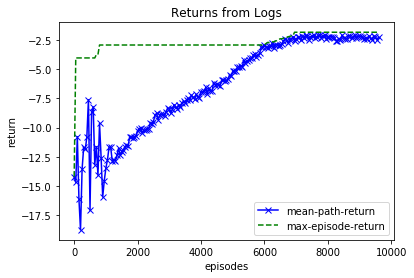

In [38]:
mean_0=np.array(df['mean-path-return_agent_0'])[::50]
mean_1=np.array(df['mean-path-return_agent_1'])[::50]
max_0=np.array(df['max-path-return_agent_0'])[::50]
max_1=np.array(df['max-path-return_agent_1'])[::50]
episode=np.array(df['episodes'])[::50]

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("episodes")
plt.ylabel("return")
plt.title("Returns from Logs")
plt.plot(episode, mean_0,color='blue',marker='x',label='mean-path-return')
plt.plot(episode,max_0, color='green', linestyle="--",label="max-episode-return")
plt.legend()
plt.show()


usage: ipykernel_launcher.py [-h] [--max-path-length MAX_PATH_LENGTH]
                             [--speedup SPEEDUP]
                             file
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/home/siphelele/anaconda3/envs/masql/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
